In [1]:
!pip install opencv-python

In [2]:
# Display
import matplotlib.pyplot as plt
# Directory
import cv2
import os
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Convert images to array of floats
import numpy as np

2024-12-05 10:58:53.823122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 10:58:57.935813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

device = "/GPU:0"

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-12-05 10:59:02.909580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 10:59:03.034425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 10:59:03.038261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Display

In [4]:
# Display
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow((images[i].astype(as_type) + 1) / 2, cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


# Load image dataset

In [5]:
train = np.loadtxt("text_data/cat_data.txt")
train = train.reshape((29843, 64, 64, 3))
train.shape

(29843, 64, 64, 3)

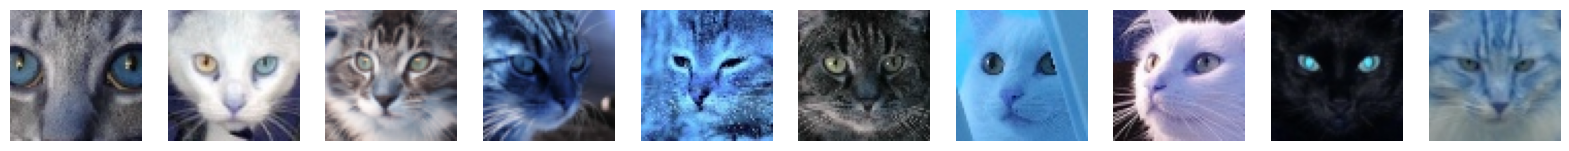

In [6]:
display(train[:10])

# Create Dataset

In [7]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(train[:29823])

2024-12-05 11:02:04.895657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:02:04.902875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 11:02:04.906995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
dataset = dataset.shuffle(29824)

In [9]:
dataset = dataset.batch(batch_size)
# Prefetch done so I don't need to wait as long
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# GAN Time

In [10]:
# Discriminator
discriminator_input = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias = False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)

x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias = False,
    activation = 'sigmoid'
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)

In [11]:
# Generator
generator_input = layers.Input(shape=(100,)) 
x = layers.Reshape((1, 1, 100))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)

x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    3,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias = False,
    activation = 'tanh'
)(x)

generator = models.Model(generator_input, generator_output)

2024-12-05 11:02:18.664631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


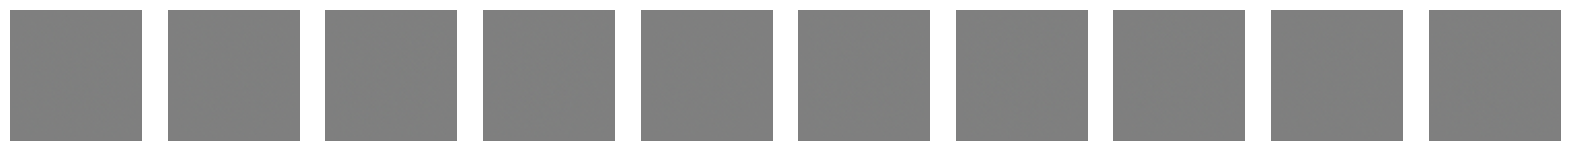

In [12]:
random_latent_vectors = tf.random.normal(
    shape=(batch_size, 100)
)
generated = generator(random_latent_vectors, training=False)

display(generated.numpy()[:10])

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses, metrics

class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training = True
            )
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(
                generated_images, training = True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(
                tf.shape(fake_predictions)
            )
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        ) 
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=100
)


dcgan.compile(
    d_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    g_optimizer=Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
)

dcgan.fit(train, epochs=100)

2024-12-05 11:02:23.175105: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1466843136 exceeds 10% of free system memory.
2024-12-05 11:02:26.243245: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1466843136 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1733418154.398137   26094 service.cc:145] XLA service 0x7dca500025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733418154.398237   26094 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-05 11:02:34.674078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1733418154.907724   26094 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform


  9/933 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - d_loss: 0.7514 - g_loss: 1.2196 

I0000 00:00:1733418179.063934   26094 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


933/933 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - d_loss: 0.0652 - g_loss: 4.4113
Epoch 2/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.3143 - g_loss: 2.7364
Epoch 3/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.3487 - g_loss: 2.4328
Epoch 4/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2803 - g_loss: 2.6516
Epoch 5/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2398 - g_loss: 2.9045
Epoch 6/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2447 - g_loss: 2.9187
Epoch 7/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2668 - g_loss: 2.9226
Epoch 8/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2693 - g_loss: 2.8964
Epoch 9/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2356 - g_loss: 2.9375
Epoch 10/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2526 - g_loss: 2.9881
Epoch 11/100
933/933 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 0.2067 - g_loss: 3.2161
Epoch 12/100
933/933 ━━━━━━━━━━

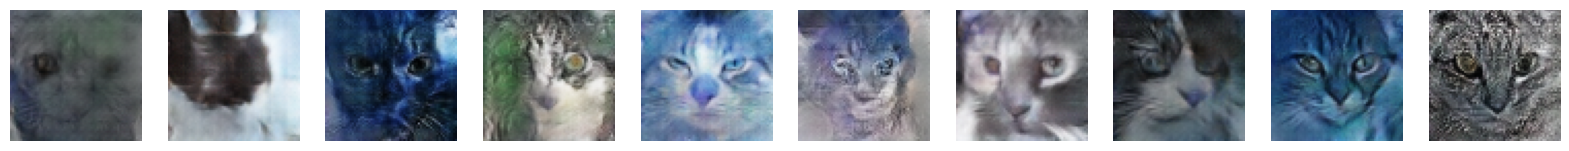

In [14]:
random_latent_vectors = tf.random.normal(
    shape=(batch_size, 100)
)
generated = dcgan.generator(random_latent_vectors, training=False)

display(generated.numpy()[:10])

In [15]:
def gradient_penalty(self, batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = self.critic(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp